In [1]:
!pip install nltk


In [2]:
#ST10072411 Brice Agnew
#24/06/2025
#Prog8411 POE part 3
#Sentiment Analysis


#Imports
import nltk

try:
    nltk.data.find('sentiment/vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')
# tries to find the vader_lexicon, and if not, downloads to the 'C:\Users\<user>\AppData\Roaming\nltk_data' directory

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import pandas as pd
import re

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download only once, ensuring that required NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\brice\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brice\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Data Collection

#open chosen dataset csv file
#Please be sure to keep the attached csv files in the same root repository before running!
Dataset = pd.read_csv("PDANA_POE_rawdata.csv")


In [4]:
#Exploratory Data Analysis: Part 1
Dataset.head(7)


,id,user_id,created_at,authorDisplayName,author,authorAvatar,author_id,review_title,review_rating,review_content,...,industry_name,industry_slug,status_id,nps_rating,source,is_reported,business_reporting,author_created_date,author_total_reviews_count,attachments
0,4228893,0cf37140-f94c-11ec-9b49-19cd672a8c8b,2022-12-16 20:51:27,Werner S,Werner S,NaN,0cf37140-f94c-11ec-9b49-19cd672a8c8b,Not telkpm,1,I pay R519 per month and can't signin on the ...,...,Telecommunications,telecommunications,1,NaN,WEBSITE,False,NaN,2022-07-01,3,[]
1,4228846,364faaf0-5104-11ec-8045-7d7a9af8c558,2022-12-16 18:54:28,Nokuthula K,Nokuthula K,NaN,364faaf0-5104-11ec-8045-7d7a9af8c558,Please help me clear my name,1,I can't even buy a house because telkom failed...,...,Telecommunications,telecommunications,1,NaN,WEBSITE,False,NaN,2021-11-29,3,[]
2,4228766,0c8502a0-5ee0-11ea-9899-6f17cff30ea1,2022-12-16 16:28:46,Services A,Services A,NaN,0c8502a0-5ee0-11ea-9899-6f17cff30ea1,Untrustworthy business,1,I was contacted if I wanted to upgrade a data ...,...,Telecommunications,telecommunications,1,NaN,WEBSITE,False,NaN,2020-03-05,50,[]
3,4228626,35bf64d7-31fa-11e8-83f4-f23c91bb6188,2022-12-16 12:58:01,Nina H,Nina H,NaN,35bf64d7-31fa-11e8-83f4-f23c91bb6188,telkom,1,Have been in a fight with TELKOM since August ...,...,Telecommunications,telecommunications,1,NaN,WEBSITE,False,NaN,2017-05-06,1,[]
4,4228610,2b490ce9-31fa-11e8-83f4-f23c91bb6188,2022-12-16 12:42:24,Arshad P,Arshad P,NaN,2b490ce9-31fa-11e8-83f4-f23c91bb6188,TELKOM Killarney Looting on Upgrade,1,"-10, \nSo I have Telkom contract with Telkom f...",...,Telecommunications,telecommunications,1,NaN,WEBSITE,False,NaN,2016-07-01,5,[]
5,4228533,017368a3-31fa-11e8-83f4-f23c91bb6188,2022-12-16 11:27:08,Elaine,Elaine,NaN,017368a3-31fa-11e8-83f4-f23c91bb6188,TELKOM AND NUDEBT ARE ROGUES AND FRAUDSTERS!!!,1,TELKOM ARE ROGUES. \nTHEY STEAL OUR MONEY EVER...,...,Telecommunications,telecommunications,1,NaN,WEBSITE,False,NaN,2010-09-19,20,[]
6,4228398,3c07bdd1-31fa-11e8-83f4-f23c91bb6188,2022-12-16 08:48:06,Robyn S,Robyn S,NaN,3c07bdd1-31fa-11e8-83f4-f23c91bb6188,Despicable Service,1,If I could give this company a 1 I would. The ...,...,Telecommunications,telecommunications,1,NaN,WEBSITE,False,NaN,2018-01-11,9,[]


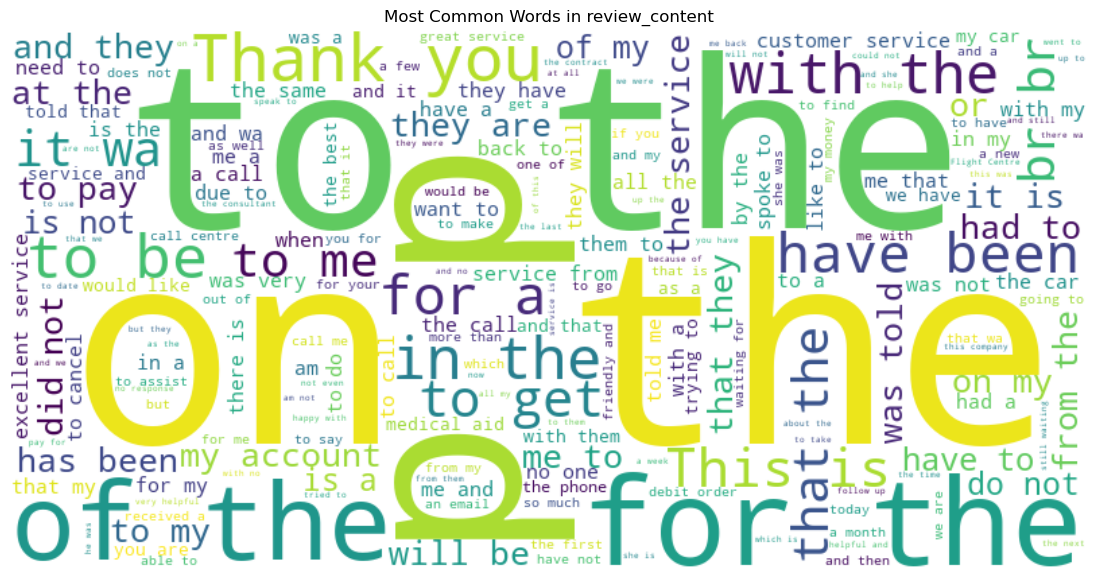

In [5]:
#Exploratory Data Analysis: Part 2

#This word cloud represents the proportional word distribution in the raw "review_content" column, which is the primary source of sentiment.
text = ' '.join(Dataset['review_content'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in review_content")
plt.show()


In [6]:
#Exploratory Data Analysis: Part 3
print("Dataset Empty value check: ")
print(Dataset.isna())
print("")

print("Number of rows:\n"
      , len(Dataset),"\n")
print("Number of Empty values:\n"
      ,Dataset.isna().any(axis=1).sum(),"\n")

#Identifying number of duplicate rows
print("Number of Duplicate rows:\n"
      ,Dataset.duplicated().sum(), "\n")


#Counting which columns have the most missing values
print("Number of missing values per column: ")
print(Dataset.isna().sum())
print("")

#investigating datatypes and column names 
print("Data types per column: ")
print(Dataset.dtypes)



Dataset Empty value check: 
          id  user_id  created_at  authorDisplayName  author  authorAvatar  \
0      False    False       False              False   False          True   
1      False    False       False              False   False          True   
2      False    False       False              False   False          True   
3      False    False       False              False   False          True   
4      False    False       False              False   False          True   
...      ...      ...         ...                ...     ...           ...   
56255  False    False       False              False   False          True   
56256  False    False       False              False   False          True   
56257  False    False       False              False   False          True   
56258  False    False       False              False   False          True   
56259  False    False       False              False   False          True   

       author_id  review_title  rev

In [7]:
#Data Cleamning Pipeline:
class ReviewCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Define all irrelevant columns here for both Feature selection and Data Cleaning Steps
        self.cols_to_drop = [
            # Previously cleaned ones
            'business_reporting', 'authorAvatar', 'nps_rating', 'source', 'business_logo',
            # Feature selection irrelevant ones
            'id', 'user_id', 'created_at', 'messages', 'authorDisplayName', 'author',
            'author_id', 'attachments', 'industry_logo', 'industry_name', 'industry_slug',
            'is_reported', 'status_id', 'replied', 'author_created_date', 'permalink',
            'business_slug', 'business_name'
        ]
    
    def clean_text(self, text):
        # Remove all characters except letters, numbers, spaces, and punctuation
        return re.sub(r'[^a-zA-Z0-9\s!?.]', '', text)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        
        # Drop irrelevant columns if they exist
        X.drop(columns=[col for col in self.cols_to_drop if col in X.columns], inplace=True, errors='ignore')

        # Combine and clean review_title + review_content (For sentiment analysis and Theme identification)
        if {'review_title', 'review_content'}.issubset(X.columns):
            X['review'] = (X['review_title'].fillna('') + ' ' + X['review_content'].fillna(''))
            X['review'] = X['review'].apply(self.clean_text)
            X = X.drop(columns=['review_title', 'review_content'], errors='ignore')
            X = X.drop_duplicates()
        return X

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key='review'):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]  # return a Series, not DataFrame



In [8]:
#Data CLeaning: Part 2
ml_pipeline = Pipeline([
    ('cleaner', ReviewCleaner()),  # expects a DataFrame
    ('select_text', TextSelector('review')),  # reduce to just the 'review' column
    ('vectoriser', TfidfVectorizer(stop_words='english')),
    ('select', SelectKBest(chi2, k=1000)),
    ('model', LogisticRegression(max_iter=1000))
])



In [9]:
#Data Cleaning: Part 3
#Pipeline call
# Apply only the cleaning step
cleaned_data = ReviewCleaner().fit_transform(Dataset)

#Establishing the number of empty values remaining in the Dataset
print("Number of Empty values:\n"
      ,cleaned_data.isna().any(axis=1).sum(),"\n")

print(cleaned_data.isna().sum())
print("")

#Testing the new 'review' content
print("The review content: \n", cleaned_data['review'][0])
#Expected output: 'Not telkpm I pay R519 per month and can't signin  on the modem.  This happens when we have electricity which is about every 3 hours none after 21h00
#I would plead with potential customers not to consider telkom'




Number of Empty values:
 0 

review_rating                 0
author_total_reviews_count    0
review                        0
dtype: int64

The review content: 
 Not telkpm I pay R519 per month and cant signin  on the modem.  This happens when we have electricity which is about every 3 hours none after 21h00
I would plead with potential customers not to consider telkom


In [10]:
#Data Cleaning: Part 4
#visually representing changes
print("Number of rows:\n"
      , len(cleaned_data),"\n")
print("Number of Empty values:\n"
      ,cleaned_data.isna().any(axis=1).sum(),"\n")

#Identifying number of duplicate rows
print("Number of Duplicate rows:\n"
      ,cleaned_data.duplicated().sum(), "\n")

#Counting which columns have the most missing values
print(cleaned_data.isna().sum())
print("")

Number of rows:
 55926 

Number of Empty values:
 0 

Number of Duplicate rows:
 0 

review_rating                 0
author_total_reviews_count    0
review                        0
dtype: int64



In [11]:
#Sentiment Analysis:
#using the SentimentIntensityAnalyzer package from the NLTK library, specifically the vader 
#SIA doesnt require training, which does make the process simpler. Additionally it is reported to be good at interpretting punvctuation in sentiment.

#calculate sentiment
analyzer = SIA()
cleaned_data['compound'] = [analyzer.polarity_scores(x)['compound'] for x in cleaned_data['review']]
cleaned_data['negative'] = [analyzer.polarity_scores(x)['neg'] for x in cleaned_data['review']]
cleaned_data['neutral'] = [analyzer.polarity_scores(x)['neu'] for x in cleaned_data['review']]
cleaned_data['positive'] = [analyzer.polarity_scores(x)['pos'] for x in cleaned_data['review']]

#create columns
cleaned_data['sentiment']='neutral' #Automatically setting 'overall' sentiment to being neutral before individually assigning positive or negative
cleaned_data.loc[cleaned_data.compound>0.05,'sentiment']='positive'
cleaned_data.loc[cleaned_data.compound<-0.05,'sentiment']='negative'
cleaned_data.head()

#on-screen summary
print("Neutral Total Sentiment Count: ",
      cleaned_data['sentiment'].value_counts()['neutral'])
print("Positive Total Sentiment Count: ",
      cleaned_data['sentiment'].value_counts()['positive'])
print("Negative Total Sentiment Count: ",
      cleaned_data['sentiment'].value_counts()['negative'])

cleaned_data.head(5)

Neutral Total Sentiment Count:  1884
Positive Total Sentiment Count:  34192
Negative Total Sentiment Count:  19850


,review_rating,author_total_reviews_count,review,compound,negative,neutral,positive,sentiment
0,1,3,Not telkpm I pay R519 per month and cant signi...,0.0762,0.000,0.963,0.037,positive
1,1,3,Please help me clear my name I cant even buy a...,0.8608,0.055,0.768,0.177,positive
2,1,50,Untrustworthy business I was contacted if I wa...,-0.5994,0.079,0.890,0.031,negative
3,1,1,telkom Have been in a fight with TELKOM since ...,-0.9672,0.216,0.706,0.078,negative
4,1,5,TELKOM Killarney Looting on Upgrade 10 \nSo I ...,-0.9656,0.101,0.861,0.038,negative


In [12]:
#Model training:
required_columns = {'review', 'sentiment'}

# Check if required columns exist
if not required_columns.issubset(cleaned_data.columns):
    missing = required_columns - set(cleaned_data.columns)
    raise ValueError(f"Columns missing from dataset: {missing}")

# Proceed only if columns exist
cleaned_data = cleaned_data.dropna(subset=['review', 'sentiment'])
#cleaned_data= cleaned_data.drop(columns=['review_title', 'review_content'], errors='ignore')

X = cleaned_data  # needed by ReviewCleaner
y = cleaned_data['sentiment']

# Convert labels to numeric if needed
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Length of X:", len(X))
print("Length of y:", len(y_encoded))

# Split data
#X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=69)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=69)

# Fit model
ml_pipeline.fit(X_train, y_train)

# Predict
preds = ml_pipeline.predict(X_test)

# Evaluate
print(classification_report(y_test, preds, target_names=le.classes_))

cleaned_data.head()


Length of X: 55926
Length of y: 55926
              precision    recall  f1-score   support

    negative       0.80      0.90      0.85      3934
     neutral       0.82      0.12      0.21       354
    positive       0.91      0.89      0.90      6898

    accuracy                           0.87     11186
   macro avg       0.85      0.63      0.65     11186
weighted avg       0.87      0.87      0.86     11186



,review_rating,author_total_reviews_count,review,compound,negative,neutral,positive,sentiment
0,1,3,Not telkpm I pay R519 per month and cant signi...,0.0762,0.000,0.963,0.037,positive
1,1,3,Please help me clear my name I cant even buy a...,0.8608,0.055,0.768,0.177,positive
2,1,50,Untrustworthy business I was contacted if I wa...,-0.5994,0.079,0.890,0.031,negative
3,1,1,telkom Have been in a fight with TELKOM since ...,-0.9672,0.216,0.706,0.078,negative
4,1,5,TELKOM Killarney Looting on Upgrade 10 \nSo I ...,-0.9656,0.101,0.861,0.038,negative


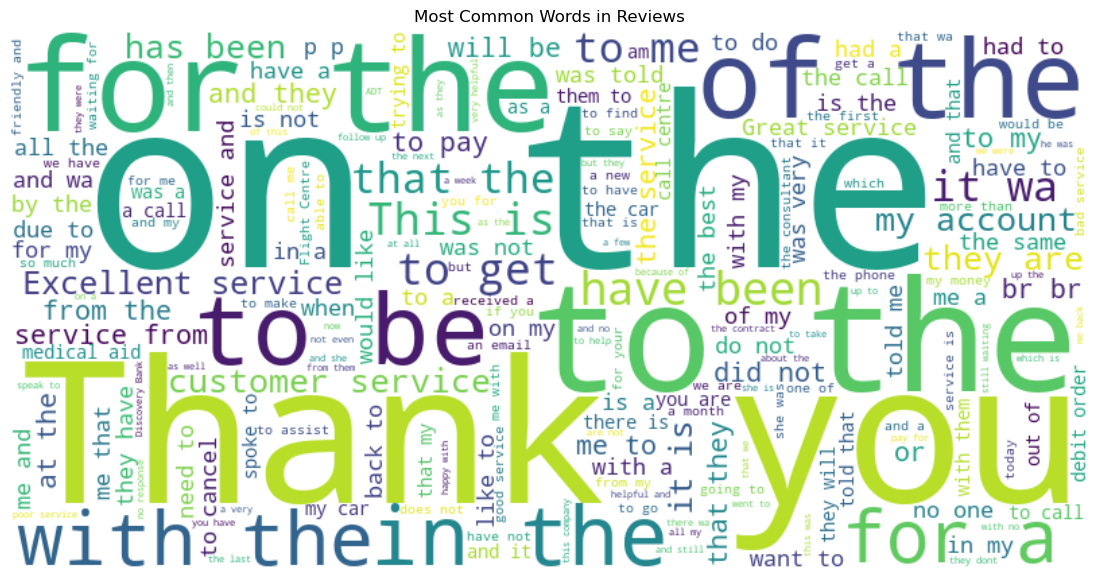

In [13]:
#Visualization of word frequency in reviews
text = ' '.join(cleaned_data['review'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Reviews")
plt.show()


In [14]:
#Concern Identification: Part 1
#Most frequently occuring words/concerns

# Prepare stopwords as a set for faster lookup
stop_words = set(stopwords.words('english'))

# Initialize counter
token_counts = Counter()

# Iterate over each review
for review in cleaned_data['review'].dropna().astype(str):
    tokens = word_tokenize(review.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    token_counts.update(tokens)
#the first version I tried with this involved compiling every review into a string to search through, but that had insane levels of overhead
#so this secondary version was developed to instead use a counter object and for loop to more efficiently search through the tokens found.

#Uses the token_count counter data to create a dataframe for display. 
freq_df = pd.DataFrame(token_counts.items(), columns=['word', 'frequency'])
freq_df['frequency'] = freq_df['frequency'].astype(int)
freq_df = freq_df.sort_values(by='frequency', ascending=False)

print("Most frequently occuring words:")
freq_df.head(50)


Most frequently occuring words:


,word,frequency
127,service,43802
153,call,16070
70,get,15030
12,would,12597
219,time,12015
61,still,11223
499,received,11032
162,told,10778
1975,thank,10677
392,back,10490


In [15]:
#Concern Identification: Part 2
#Manually seperating concerns into themes, and identifying the most commonly occuring themes

themes = {
    'Billing' : ['pay', 'money', 'account', 'paid', 'bank', 'number', 'debit','bill'],
    'Customer Service':['call', 'called', 'told', 'said', 'email', 'customer', 'help', 'please', 'service', 'sent', 'br'],
    'Product' :['telkom', 'company', 'network', 'phone', 'work', 'internet'],
    'Timeliness':['time', 'days', 'day', 'month', 'still', 'back', 'never'],
    'Complaints':['dont', 'need', 'want', 'im', 'never', 'get', 'like', 'made', 'one'],
    'Positive Sentiment':['thank', 'great', 'good', 'excellent'],
    'Ambiguous':['br','p']
}
theme_counts = {}

#iterating through the previous frequency distribution to assign each keyword to a theme
for theme, keywords in themes.items():
    total = sum(freq_df[freq_df['word'].isin(keywords)]['frequency'])
    theme_counts[theme] = total

theme_df = pd.DataFrame(list(theme_counts.items()), columns=['Concern', 'Mentions'])

#Presenting the most commonly occuring 
print("[Most commonly occuring concerns:]")

theme_df.head(20).sort_values(by='Mentions', ascending=False)

[Most commonly occuring concerns:]


,Concern,Mentions
1,Customer Service,127479
4,Complaints,71285
3,Timeliness,60504
0,Billing,46656
5,Positive Sentiment,36586
2,Product,31441
6,Ambiguous,13674


In [16]:
#References:

#Govindasamy, A.D., 2023. Business Reviews from different Industries. [online] kaggle.com. Available at: <https://www.kaggle.com/datasets/ashlingovindasamy/business-reviews-from-different-industries?select=trainingData.csv> [Accessed 24 June 2025].
#Mogyorosi, M., 2025. Sentiment Analysis: First Steps With Python’s NLTK Library. [online] realpython.com. Available at: <https://realpython.com/python-nltk-sentiment-analysis/> [Accessed 24 June 2025].
#pandas.pydata.org, 2025a. pandas.DataFrame.drop. [online] pandas.pydata.org. Available at: <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html> [Accessed 24 June 2025].
#pandas.pydata.org, 2025b. pandas.DataFrame.dropna. [online] pandas.pydata.org. Available at: <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html> [Accessed 24 June 2025].
#www.nltk.com, 2025. nltk.sentiment.SentimentIntensityAnalyzer. [online] www.nltk.com. Available at: <https://www.nltk.org/api/nltk.sentiment.SentimentIntensityAnalyzer.html?highlight=sentimentintensity> [Accessed 27 June 2025].
#www.nltk.org, n.d. nltk.corpus package. www.nltk.org. [online] Available at: <https://www.nltk.org/api/nltk.corpus.html> [Accessed 27 June 2025a].
#www.nltk.org, n.d. nltk.tokenize package. www.nltk.org. [online] Available at: <https://www.nltk.org/api/nltk.tokenize.html> [Accessed 27 June 2025b].
